In [83]:
#Import all modules. Set path for iimporting dishpill_models

import sys
import os
import pathlib
import datetime
import numpy as np
import pandas as pd
import scipy
import scipy.stats as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pingouin as pg
pd.options.display.max_columns = 150
%matplotlib inline
sns.set()
pd.set_option('display.max_rows', 250)
sns.set_style("whitegrid")
from scipy.stats import ttest_ind
from statsmodels.stats.anova import AnovaRM
import warnings
warnings.filterwarnings('ignore')
path = "../models"
if not path in sys.path:
    sys.path.append(path)
%reload_ext autoreload
%autoreload 1
from statannot import add_stat_annotation
import math

import dishpill_models

In [84]:
#group_data takes a pandas data frame and a list of tags, and assigns: whether it is a control trials,
#    a rounded elapsed minute to each trial, and groups into two timepoints or "halfs". 
def group_data(dataframe, tag_list):
    print("Chosen tags are", tag_list)
    df = dataframe
    mask = df['tag'].isin(tag_list)
    df = df[mask]
    group = df['tag'].str.contains('ctl', case = False)
    df['group'] = group.astype(int)
    halfmask = df['elapse_seconds']>t1
    df['elapse_minute_rounded'] = np.int32(df['elapse_seconds'] / 60.)
    df.loc[:,'half'] = halfmask
    df["half"] = df["half"].astype(int)
    
    #df = df[df['hit_count']>0]
    df
    return df

In [85]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 3)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

In [86]:
df = pd.read_pickle('Data/in_vitro_cells_sentience_corr.pkl')
#df = pd.read_pickle('Data/in_vitro_cells_sentience_corr.pkl')
df = df.rename(columns={"elapse_minute_rounded": "minute", "session_num": "session", "elapse_seconds": "second"}, errors="raise")


In [87]:
df.group.unique()

array([4, 2, 3, 0, 1])

In [88]:
activitydf = pd.read_pickle('spikedatacorrsall100ms.pkl')

activitydf['chip_id'] = activitydf['chip_id'].str.extract('(\d+)', expand=False)
len(activitydf.tag.unique())

14

In [89]:
df['date'] = pd.to_datetime(df['date'])
activitydf['date'] = pd.to_datetime(activitydf['date'])
df['session'] = pd.to_numeric(df['session'])
activitydf['session'] = pd.to_numeric(activitydf['session'])
df['session'] = df['session'].astype('int64')
activitydf['session'] = activitydf['session'].astype('int64')
df['chip_id'] = df['chip_id'].astype('int64')
activitydf['chip_id'] = activitydf['chip_id'].astype('int64')


In [134]:
meanActivitydf = activitydf.groupby(['group', 'chip_id', 'date', 'session', 'minute']).mean()
meanActivitydf = meanActivitydf.reset_index()
meanGamedf = df.groupby(['group','chip_id', 'date', 'session', 'minute']).mean()
meanGamedf = meanGamedf.reset_index()
alldf = meanGamedf.merge(meanActivitydf, how='outer', on = ['group', 'chip_id', 'date', 'session', 'minute'])
alldf = alldf[alldf.group  != 4]
alldf = alldf[alldf.group  != 1]
alldf = alldf[alldf.group  != 3]
alldf = alldf[alldf.minute  != 0]

In [135]:
alldf['firingratio'] = alldf['NormHzmotor1']/alldf['NormHzmotor2']
alldf['absfiringratio'] = (abs(alldf['firingratio']-1))
alldf['allcrossconnect'] = alldf['pmotor1Corr']*alldf['pmotor2Corr']
alldf['crossconnect'] = alldf['pmotor1Corr']*alldf['pmotor2Corr']*alldf['pmotorsCorr']

In [136]:
check = alldf.groupby(['group','chip_id', 'date']).mean()
check = check.reset_index()
len(check['chip_id'].unique())

30

In [141]:
alldf1 = alldf
alldf1['normdct01_firing'] = alldf1['dct01_firing']/alldf1['mean_firing']
alldf1['normdct10_firing'] = alldf1['dct10_firing']/alldf1['mean_firing']
alldf1['normdct02_firing'] = alldf1['dct02_firing']/alldf1['mean_firing']
alldf1['normdct20_firing'] = alldf1['dct20_firing']/alldf1['mean_firing']
alldf1['normdct01_firing'] =alldf1['normdct01_firing'].abs()
alldf1['normdct10_firing'] =alldf1['normdct10_firing'].abs()
alldf1['normdct02_firing'] =alldf1['normdct02_firing'].abs()
alldf1['normdct20_firing'] =alldf1['normdct20_firing'].abs()
alldf1['Sensoryfiring']=(alldf1['NormHzSensory']*626)
alldf1['Motor1Firing']=(alldf1['NormHzmotor1']*198)
alldf1['Motor2Firing']=(alldf1['NormHzmotor2']*200)


alldf1['Zmean_firing'] = (alldf1.mean_firing - alldf1.mean_firing.mean())/alldf1.mean_firing.std(ddof=0) 
alldf1['Zmean_firing'] = alldf1['Zmean_firing'].abs()
alldf1 = alldf1[alldf1.Zmean_firing <= 3.29]

alldf1['Zmax_firing'] = (alldf1.max_firing - alldf1.max_firing.mean())/alldf1.max_firing.std(ddof=0) 
alldf1['Zmax_firing'] = alldf1['Zmax_firing'].abs()
alldf1 = alldf1[alldf1.Zmax_firing <= 3.29]



alldf1['ZNormHzSensory'] = (alldf1.NormHzSensory - alldf1.NormHzSensory.mean())/alldf1.NormHzSensory.std(ddof=0) 
alldf1['ZNormHzSensory'] = alldf1['ZNormHzSensory'].abs()
alldf1 = alldf1[alldf1.ZNormHzSensory <= 3.29]

alldf1['ZNormHzmotor1'] = (alldf1.NormHzmotor1 - alldf1.NormHzmotor1.mean())/alldf1.NormHzmotor1.std(ddof=0) 
alldf1['ZNormHzmotor1'] = alldf1['ZNormHzmotor1'].abs()
alldf1 = alldf1[alldf1.ZNormHzmotor1 <= 3.29]

alldf1['ZNormHzmotor2'] = (alldf1.NormHzmotor2 - alldf1.NormHzmotor2.mean())/alldf1.NormHzmotor2.std(ddof=0) 
alldf1['ZNormHzmotor2'] = alldf1['ZNormHzmotor2'].abs()
alldf1 = alldf1[alldf1.ZNormHzmotor2 <= 3.29]

alldf1['Zpmotor1Corr'] = (alldf1.pmotor1Corr - alldf1.pmotor1Corr.mean())/alldf1.pmotor1Corr.std(ddof=0) 
alldf1['Zpmotor1Corr'] = alldf1['Zpmotor1Corr'].abs()
alldf1 = alldf1[alldf1.Zpmotor1Corr <= 3.29]

alldf1['Zpmotor2Corr'] = (alldf1.pmotor2Corr - alldf1.pmotor2Corr.mean())/alldf1.pmotor2Corr.std(ddof=0) 
alldf1['Zpmotor2Corr'] = alldf1['Zpmotor2Corr'].abs()
alldf1 = alldf1[alldf1.Zpmotor2Corr <= 3.29]

alldf1['Zabsfiringratio'] = (alldf1.absfiringratio - alldf1.absfiringratio.mean())/alldf1.absfiringratio.std(ddof=0) 
alldf1['Zabsfiringratio'] = alldf1['Zabsfiringratio'].abs()
alldf1 = alldf1[alldf1.Zabsfiringratio <= 3.29]

alldf1['Zhit_count'] = (alldf1.hit_count - alldf1.hit_count.mean())/alldf1.hit_count.std(ddof=0) 
alldf1['Zhit_count'] = alldf1['Zhit_count'].abs()
alldf1 = alldf1[alldf1.Zhit_count <= 3.29]

meanAlldf = alldf1.groupby(['group','chip_id', 'date', 'session']).mean()
meanAlldf = meanAlldf.reset_index()

In [143]:
exp_corr2 = meanAlldf[((meanAlldf.group == 0) | (meanAlldf.group == 2))]
pg.pairwise_corr(exp_corr2, method='pearson', columns=['hit_count']).round(3)

X                 Y   method       tail    n      r  \
0   hit_count             group  pearson  two-sided  302 -0.334   
1   hit_count           chip_id  pearson  two-sided  302  0.161   
2   hit_count           session  pearson  two-sided  302  0.064   
3   hit_count            minute  pearson  two-sided  302 -0.001   
4   hit_count          second_x  pearson  two-sided  302  0.004   
5   hit_count       mean_firing  pearson  two-sided  302  0.240   
6   hit_count        max_firing  pearson  two-sided  302  0.231   
7   hit_count        var_firing  pearson  two-sided  302  0.276   
8   hit_count       norm_firing  pearson  two-sided  302  0.307   
9   hit_count        q95_firing  pearson  two-sided  302  0.211   
10  hit_count        q90_firing  pearson  two-sided  302  0.193   
11  hit_count        q75_firing  pearson  two-sided  302  0.175   
12  hit_count        q50_firing  pearson  two-sided  302  0.168   
13  hit_count      dct00_firing  pearson  two-sided  302  0.236   
14  hit_count      dct01_firing  pearson  two-sided  302 -0.077   
15  hit_count      dct02_firing  pearson  two-sided  302  0.014   
16  hit_count      dct10_firing  pearson  two-sided  302 -0.158   
17  hit_count      dct11_firing  pearson  two-sided  302  0.201   
18  hit_count      dct12_firing  pearson  two-sided  302 -0.185   
19  hit_count      dct20_firing  pearson  two-sided  302 -0.166   
20  hit_count      dct21_firing  pearson  two-sided  302 -0.049   
21  hit_count      dct22_firing  pearson  two-sided  302 -0.070   
22  hit_count              half  pearson  two-sided  302  0.044   
23  hit_count        long_rally  pearson  two-sided  302  0.801   
24  hit_count               ace  pearson  two-sided  302 -0.726   
25  hit_count          second_y  pearson  two-sided  302 -0.001   
26  hit_count     NormHzSensory  pearson  two-sided  302  0.176   
27  hit_count      NormHzmotor1  pearson  two-sided  302  0.229   
28  hit_count      NormHzmotor2  pearson  two-sided  302  0.243   
29  hit_count            events  pearson  two-sided  302 -0.038   
30  hit_count       smotor1Corr  pearson  two-sided  302  0.237   
31  hit_count       smotor2Corr  pearson  two-sided  302  0.211   
32  hit_count       smotorsCorr  pearson  two-sided  302  0.190   
33  hit_count       pmotor1Corr  pearson  two-sided  302  0.264   
34  hit_count       pmotor2Corr  pearson  two-sided  302  0.242   
35  hit_count       pmotorsCorr  pearson  two-sided  302  0.082   
36  hit_count       firingratio  pearson  two-sided  302 -0.121   
37  hit_count    absfiringratio  pearson  two-sided  302 -0.086   
38  hit_count   allcrossconnect  pearson  two-sided  302  0.222   
39  hit_count      crossconnect  pearson  two-sided  302  0.191   
40  hit_count  normdct01_firing  pearson  two-sided  302 -0.129   
41  hit_count  normdct10_firing  pearson  two-sided  302  0.009   
42  hit_count  normdct02_firing  pearson  two-sided  302 -0.088   
43  hit_count  normdct20_firing  pearson  two-sided  302 -0.142   
44  hit_count     Sensoryfiring  pearson  two-sided  302  0.176   
45  hit_count      Motor1Firing  pearson  two-sided  302  0.229   
46  hit_count      Motor2Firing  pearson  two-sided  302  0.243   
47  hit_count      Zmean_firing  pearson  two-sided  302  0.157   
48  hit_count       Zmax_firing  pearson  two-sided  302  0.107   
49  hit_count    ZNormHzSensory  pearson  two-sided  302  0.014   
50  hit_count     ZNormHzmotor1  pearson  two-sided  302  0.259   
51  hit_count     ZNormHzmotor2  pearson  two-sided  302  0.101   
52  hit_count      Zpmotor1Corr  pearson  two-sided  302 -0.100   
53  hit_count      Zpmotor2Corr  pearson  two-sided  302 -0.078   
54  hit_count   Zabsfiringratio  pearson  two-sided  302 -0.146   
55  hit_count        Zhit_count  pearson  two-sided  302  0.500   

             CI95%     r2  adj_r2      z  p-unc       BF10  power  
0   [-0.43, -0.23]  0.111   0.106 -0.347  0.000  3.207e+06  1.000  
1     [0.05, 0.27]  0.026   0.020  0.163  0.005      3.6

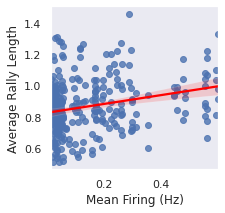

In [103]:
x = exp_corr2['mean_firing']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Mean Firing (Hz)')
ax.grid(False)
sns.set(rc={'figure.figsize':(3,3)})
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/meanfiringreg.pdf', bbox_inches='tight') 

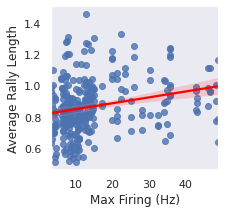

In [104]:
x = exp_corr2['max_firing']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Max Firing (Hz)')
ax.grid(False)
sns.set(rc={'figure.figsize':(3,3)})
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/maxfiringreg.pdf', bbox_inches='tight') 

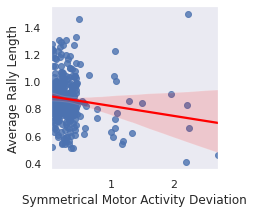

In [119]:
x = exp_corr2['Zabsfiringratio']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Symmetrical Motor Activity Deviation')
ax.grid(False)
sns.set(rc={'figure.figsize':(3,3)})
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/absfiringratioreg.pdf', bbox_inches='tight') 

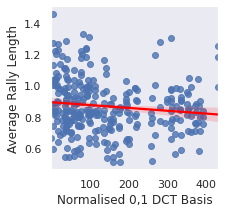

In [106]:
x = exp_corr2['normdct01_firing']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Normalised 0,1 DCT Basis')
ax.grid(False)
sns.set(rc={'figure.figsize':(3,3)})
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/normdct01_firingreg.pdf', bbox_inches='tight') 

In [107]:
x = exp_corr2['normdct20_firing']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Normalised 2,0 DCT Basis')
ax.grid(False)
sns.set(rc={'figure.figsize':(3,3)})
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/normdct20_firingreg.pdf', bbox_inches='tight')

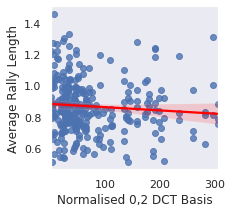

In [108]:
x = exp_corr2['normdct02_firing']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Normalised 0,2 DCT Basis')
ax.grid(False)
sns.set(rc={'figure.figsize':(3,3)})
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/normdct02_firingreg.pdf', bbox_inches='tight')

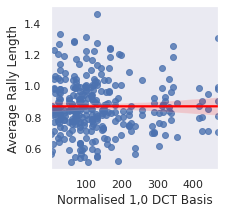

In [109]:
x = exp_corr2['normdct10_firing']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Normalised 1,0 DCT Basis')
ax.grid(False)
sns.set(rc={'figure.figsize':(3,3)})
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/normdct10_firingreg.pdf', bbox_inches='tight')

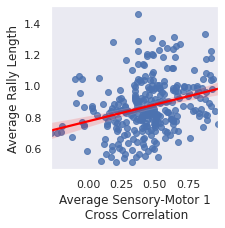

In [110]:
x = exp_corr2['pmotor1Corr']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
plt.xticks([0.00, 0.25, 0.50, 0.75])
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Average Sensory-Motor 1\n Cross Correlation')
ax.grid(False)

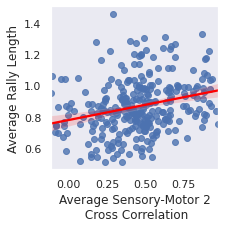

In [111]:
x = exp_corr2['pmotor2Corr']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
plt.xticks([0.00, 0.25, 0.50, 0.75])
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Average Sensory-Motor 2\n Cross Correlation')
ax.grid(False)
sns.set(rc={'figure.figsize':(3,3)})
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/pmotor2Corrreg.pdf', bbox_inches='tight')

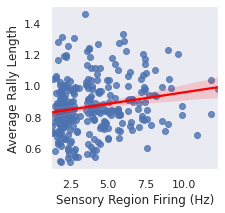

In [112]:
x = exp_corr2['Sensoryfiring']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Sensory Region Firing (Hz)')
ax.grid(False)
sns.set(rc={'figure.figsize':(3,3)})
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/NormHzSensoryreg.pdf', bbox_inches='tight')

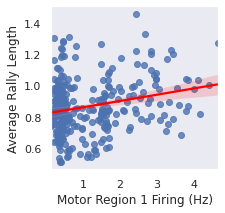

In [113]:
x = exp_corr2['Motor1Firing']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Motor Region 1 Firing (Hz)')
ax.grid(False)
sns.set(rc={'figure.figsize':(3,3)})
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/Motor1Firingreg.pdf', bbox_inches='tight')

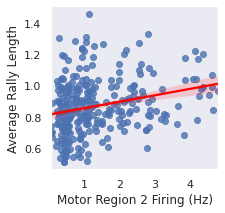

In [114]:
x = exp_corr2['Motor2Firing']
y = exp_corr2['hit_count']
f, ax = plt.subplots()
#ax.xaxis.update_units(x)
sns.regplot(x=x, y=y, line_kws={"color": "red"})
sns.set(style="darkgrid")
#ax.set_xlim([-1, 6])
ax.set_ylabel('Average Rally Length')
ax.set_xlabel('Motor Region 2 Firing (Hz)')
ax.grid(False)
sns.set(rc={'figure.figsize':(3,3)})
plt.savefig('/home/jovyan/work/dishpill/Analysis/Plots/Motor2Firingreg.pdf', bbox_inches='tight')